In this approach we will make almost everything the same as in kmeans+svm

Except for the fact that we will use SMOTE to destroy imbalance in our data

Moreover we will see what SHAP will tell us about feature importance, maybe these clusters are redundant information

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC


%matplotlib inline
np.random.seed(59)

# set the max columns to none
pd.set_option('display.max_columns', None)

In [30]:
from preprocessing import *

path = 'data\\train.csv'

df = pd.read_csv(path)
df = convert_data(df)
df = engineer_features(df)
df = select_features(df)
df.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,state_MD,state_MN,state_NJ,state_TX,state_WV,state_other,avg_mt_minutes,avg_mt_calls,avg_mt_charge,avg_call_charge,avg_intl_call_charge,avg_call_minutes,avg_intl_call_minutes,both_plans
0,107,0,1,26,13.7,3,3.70,1,0,611.5,329,55.54,0,1,0,0,0,0,0,0,1,5.714953,3.074766,0.519065,0.168815,1.233333,1.858663,4.566667,0
1,137,0,0,0,12.2,5,3.29,0,0,527.2,328,59.00,0,1,0,0,0,1,0,0,0,3.848175,2.394161,0.430657,0.179878,0.658000,1.607317,2.440000,0
2,84,1,0,0,6.6,7,1.78,2,0,558.2,248,65.02,1,0,0,0,0,0,0,0,1,6.645238,2.952381,0.774048,0.262177,0.254286,2.250806,0.942857,0
3,75,1,0,0,10.1,3,2.73,3,0,501.9,356,49.36,0,1,0,0,0,0,0,0,1,6.692000,4.746667,0.658133,0.138652,0.910000,1.409831,3.366667,0
4,121,0,1,24,7.5,7,2.03,3,0,779.3,314,76.28,0,0,1,0,0,0,0,0,1,6.440496,2.595041,0.630413,0.242930,0.290000,2.481847,1.071429,0


In [31]:
X = df.drop('churn', axis=1)
y = df['churn']

In [32]:
from collections import Counter
from imblearn.combine import SMOTEENN

# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTEENN()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 3652, 1: 598})
Counter({1: 3216, 0: 2182})


In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,
                                                  random_state=59)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5,
                                                random_state=59)

print('Train size:', len(X_train))
print('Validation size:', len(X_val))
print('Test size:', len(X_test))

Train size: 3778
Validation size: 810
Test size: 810


In [34]:
st_scaler = StandardScaler()

X_train_st = st_scaler.fit_transform(X_train)
X_val_st = st_scaler.transform(X_val)
X_test_st = st_scaler.transform(X_test)

In [35]:
km_list = list()

for i in range(1, 30):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=59)
    km = km.fit(X_train_st)
    
    km_list.append(pd.Series({'clusters': i, 
                              'inertia': km.inertia_,
                              'model': km}))

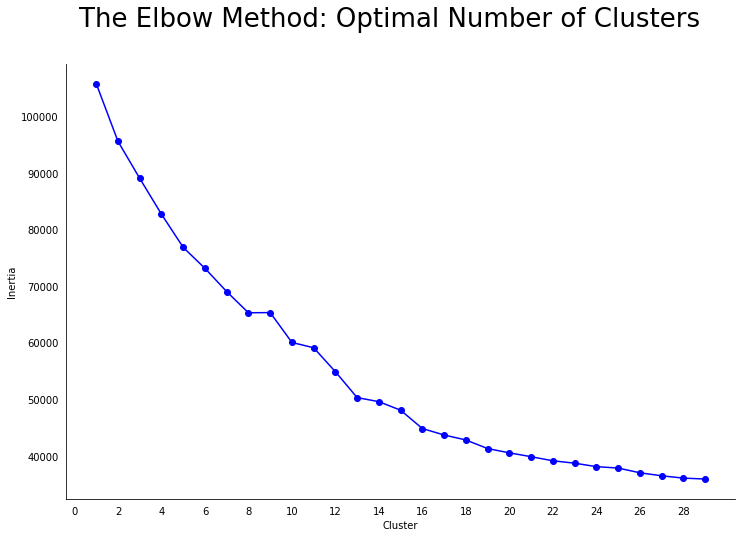

In [36]:
k = pd.concat(km_list, axis=1).T[['clusters','inertia']]

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')

plt.plot(k['clusters'], k['inertia'], 'bo-')

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top','right']:
    ax.spines[i].set_visible(False)

ax.set_xticks(range(0, 30, 2))
ax.set(xlabel='Cluster', ylabel='Inertia')

plt.suptitle('The Elbow Method: Optimal Number of Clusters', size=26)
plt.show()

In [37]:
kmeans = KMeans(n_clusters=17, max_iter=300, n_init=10, random_state=59)
kmeans.fit(X_train_st)

predicted_clusters_train = kmeans.predict(X_train_st)
X_train_st = np.column_stack((X_train_st, predicted_clusters_train))

predicted_clusters_val = kmeans.predict(X_val_st)
X_val_st = np.column_stack((X_val_st, predicted_clusters_val))

predicted_clusters_val = kmeans.predict(X_test_st)
X_test_st = np.column_stack((X_test_st, predicted_clusters_val))

In [38]:
st_scaler = StandardScaler()

X_train_st = st_scaler.fit_transform(X_train)
X_val_st = st_scaler.transform(X_val)
X_test_st = st_scaler.transform(X_test)

In [39]:
svm = SVC(probability=True)
svm.fit(X_train_st, y_train)
y_pred = svm.predict(X_val_st)

In [40]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_val, y_pred))
print('F1 Score', f1_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       333
           1       0.97      0.89      0.93       477

    accuracy                           0.92       810
   macro avg       0.91      0.92      0.92       810
weighted avg       0.92      0.92      0.92       810

F1 Score 0.9277899343544858


In [41]:
from sklearn.metrics import classification_report, f1_score

y_pred = svm.predict(X_test_st)
print(classification_report(y_test, y_pred))
print('F1 Score', f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       327
           1       0.97      0.91      0.94       483

    accuracy                           0.93       810
   macro avg       0.92      0.93      0.93       810
weighted avg       0.93      0.93      0.93       810

F1 Score 0.938034188034188


Next techniques were tried:
- SMOTE (f1 ~91)
- SMOTETomek (f1 ~92)
- SMOTEENN (f1 ~93)

The best so far is SMOTEENN